# TP Noté N°2

### 1) Mettez en œuvre le Bagging avec des arbres de profondeur 1 (en Anglais stumps), puis avec des arbres plus profonds, en partant du code ci-dessous. On pourra utiliser BaggingRegressor.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

rng = np.random.RandomState(10)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))
n_estimators = 10
tree_max_depth = 10
bagging_max_depth = 10
tree = DecisionTreeRegressor(max_depth=tree_max_depth)
tree.fit(X, y)
bagging = BaggingRegressor(tree, n_estimators=n_estimators, bootstrap = True)
bagging.fit(X, y)
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_tree = tree.predict(X_test)
y_bagging = bagging.predict(X_test)


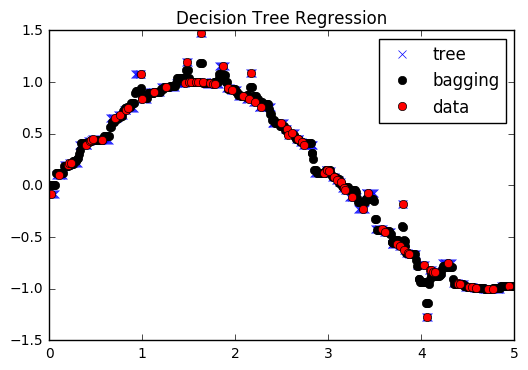

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, y_tree, 'x', c="blue", label="tree")
plt.plot(X_test, y_bagging, 'o', c="black", label="bagging")
plt.plot(X, y, 'o', c="red", label="data")
plt.title("Decision Tree Regression")
plt.legend(loc=1, numpoints=1)
plt.show()


### 2) Illustrer graphiquement le rôle de L

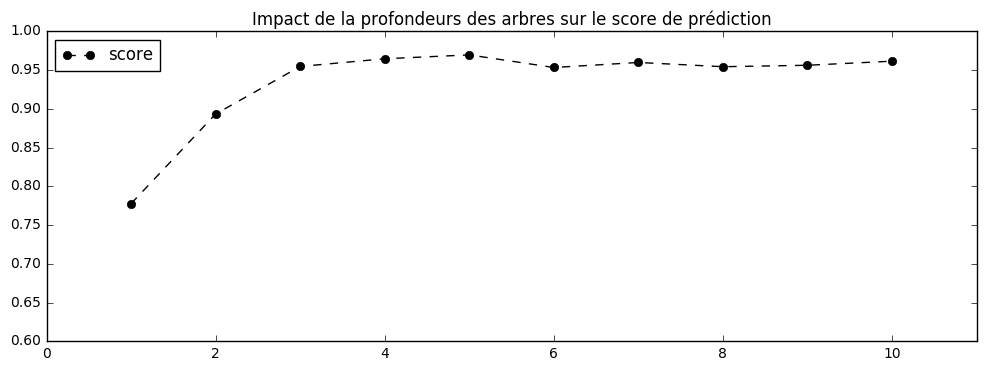

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
depths = range(1, 11, 1)
scoresDepths = []
scoresNestimators = []
for d in depths:
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(X_train, y_train)
    bagging = BaggingRegressor(tree, n_estimators=10, bootstrap = True)
    bagging.fit(X_train, y_train)
    scoresDepths.append(bagging.score(X_test,y_test))
    

plt.figure(figsize=(12, 4))
plt.plot(range(1, 11, 1), scoresDepths, 'o', c="black", label="score", linestyle='dashed')
plt.ylim(ymin=0.6, ymax = 1)
plt.xlim(xmin = 0, xmax = 11)
plt.title("Impact de la profondeurs des arbres sur le score de prédiction")
plt.legend(loc='best')
plt.show()


On voit que le score de prédiction s'améliore en fonction de la profondeur des arbres jusqu'à un plateau puis se dégrade

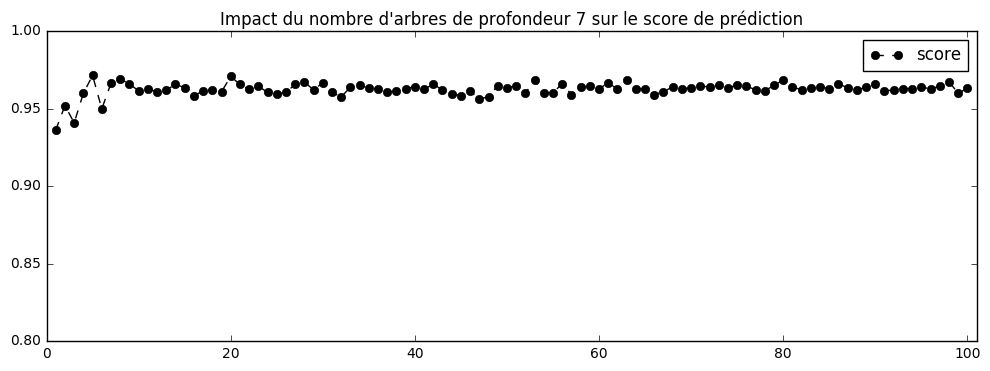

In [40]:
scoresNestimators = []
nEstimators = range(1, 101, 1)

for n in nEstimators:
    tree = DecisionTreeRegressor(max_depth=7)
    tree.fit(X_train, y_train)
    bagging = BaggingRegressor(tree, n_estimators=n, bootstrap = True)
    bagging.fit(X_train, y_train)
    scoresNestimators.append(bagging.score(X_test,y_test))
    

plt.figure(figsize=(12, 4))
plt.plot(range(1, 101, 1), scoresNestimators, 'o', c="black", label="score", linestyle='dashed')
plt.ylim(ymin=0.8, ymax = 1)
plt.xlim(xmin = 0, xmax = 101)
plt.title("Impact du nombre d'arbres de profondeur 7 sur le score de prédiction") # 7 est choisi arbitrairement
plt.legend(loc='best')
plt.show()


On voit que la variance du score diminue  quand le nombre d'estimateurs augmente.

### 3) A quoi reconnaît-on que les estimateurs construits par les arbres sont biaisés et que le *bagging* réduit leur variance ? 

Dans le code ci-dessous on calcule le biais entre un Decision tree et BaggingRegressor. Pour ce faire on génére notre échantillon d'entrainement à partir d'une loi connue et ajoutons un bruit gaussien connu sur la variable à prédire à l'entrainement. Nous pouvons ainsi calculer le biais entre les deux estimateurs et voyons (graph 2 et 4) que le biais du BaggingRegressor est inférieur au biais du DecisionTree. Même constat pour la variance qui diminue largement pour le DecisionTree

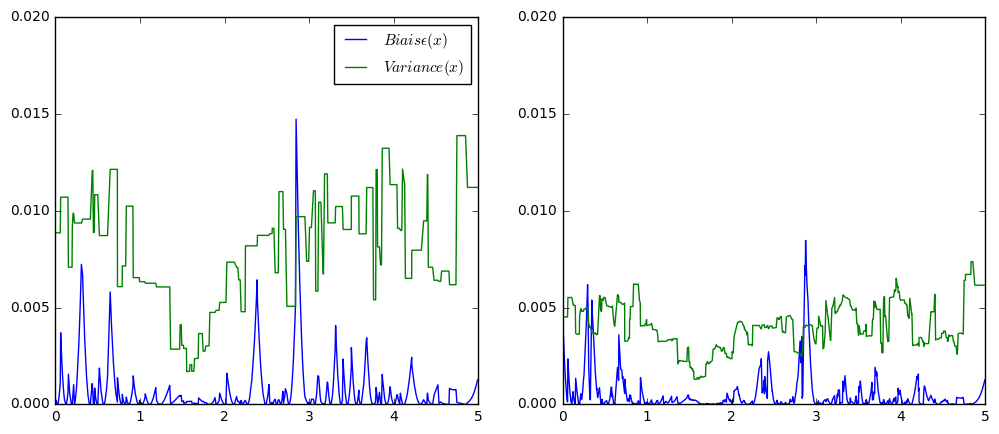

In [41]:
n_repeat = 50   
n_train = 80        
n_test = 1000       
noise = 0.1        
np.random.seed(0)

estimators = [("Tree", tree),("Bagging(Tree)", bagging)]
n_estimators = len(estimators)

# Fonction de génération d'un échantillon bruité
def generate(n_samples, noise, n_repeat=1):
    rng = np.random.RandomState(10)
    X = np.sort(5 * rng.rand(n_samples, 1), axis=0)
    #X = np.random.rand(n_samples) * 10 - 5
    if n_repeat == 1:
        y = np.sin(X).ravel() + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = np.sin(X).ravel() + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train = []
y_train = []

# Génération de n_repeat échantillons d'entrainement bruités de taille n_train
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)
    
# Génération de n_test
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)
plt.figure(figsize=(12,5))
for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)
    # Le bruit est la variance de y_test puisque il s'agit du même échantillon avec un bruit gaussien différent
    y_noise = np.var(y_test, axis=1) 
    # Le biais est la différence au carré entre la vraie valeure de y_test et la prédiction
    y_bias = (np.sin(X_test).ravel() - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)



    plt.subplot(1, n_estimators, n + 1 )
    plt.plot(X_test, y_bias, "b", label="$Biais²(x)$")
    plt.plot(X_test, y_var, "g", label="$Variance(x)$")

    plt.xlim([0, 5])
    plt.ylim([0, 0.02])

    if n == 0:
        plt.legend(loc="best", prop={"size": 11})
plt.show()


### 4) En jouant sur le niveau de bruit mettez en évidence le sur-apprentissage.


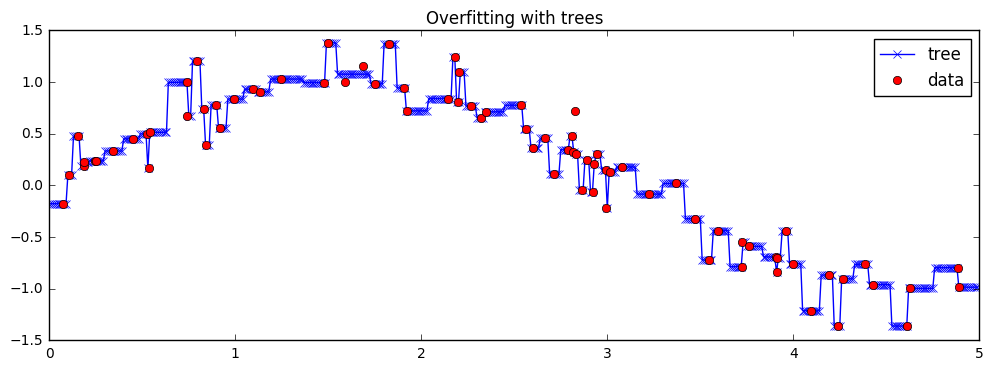

In [42]:
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::2] += 1 * (0.5 - rng.rand(40))
n_estimators = 10
tree_max_depth = 10
tree = DecisionTreeRegressor(max_depth=tree_max_depth)
tree.fit(X, y)
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_tree = tree.predict(X_test)
plt.figure(figsize=(12, 4))
plt.plot(X_test, y_tree, 'x', c="blue", label="tree", linestyle = 'solid')
plt.plot(X, y, 'o', c="red", label="data")
plt.title("Overfitting with trees")
plt.legend(loc=1, numpoints=1)
plt.show()

On voit que les prédictions de l'arbre de décision suivent les données bruitées (on a rajouté du bruit par rapport à la question 1)

### 5) Observer qu’on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons *bootstrap*

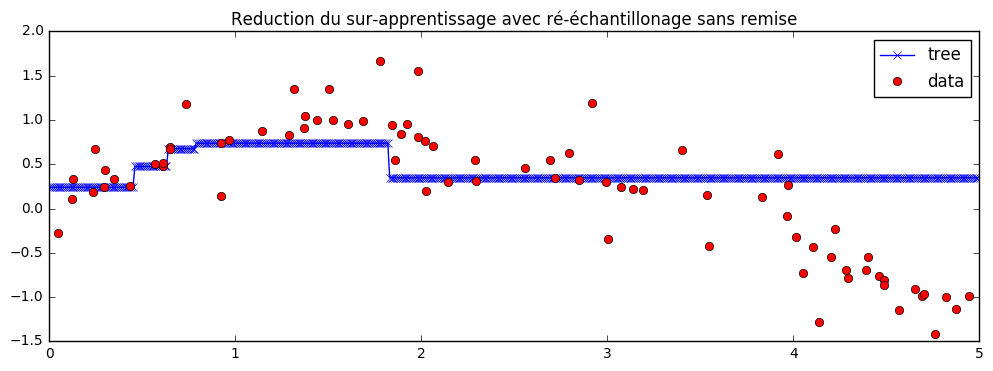

In [43]:
from sklearn.utils import resample
X = np.sort(5 * rng.rand(80, 1), axis=0)
y[::2] += 1 * (0.5 - rng.rand(40))
X_resampled, y_resampled = resample(X,y, replace = False, n_samples = 5)
tree_max_depth = 10
tree = DecisionTreeRegressor(max_depth=tree_max_depth)
tree.fit(X_resampled, y_resampled)
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_tree = tree.predict(X_test)
plt.figure(figsize=(12, 4))
plt.plot(X_test, y_tree, 'x', c="blue", label="tree", linestyle="solid")
plt.plot(X, y, 'o', c="red", label="data")
plt.title("Reduction du sur-apprentissage avec ré-échantillonage sans remise")
plt.legend(loc=1, numpoints=1)
plt.show()

Nous pouvons voir que le ré échantillonage a réduit fortement le sur-apprentissage 

### 6) Évaluez le score par 7-fold cross-validation des Random Forests sur les datasets boston, diabetes, iris et digits. Comparez ces performances avec celles d’un SVM linéaire.

In [44]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import load_diabetes
from sklearn.svm import SVC, SVR
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
import numpy as np


In [45]:
boston = load_boston()
rfr = RandomForestRegressor()
svr = SVR(kernel='linear')
X  = preprocessing.StandardScaler().fit_transform(boston.data)
y = boston.target
print("Score 7-fold du random forests %.2f" % np.mean(cross_val_score(rfr, X, y, n_jobs=-1, cv = 7)),
      "Score 7-fold du SVR %.2f" % np.mean(cross_val_score(svr, X, y)))

Score 7-fold du random forests 0.63 Score 7-fold du SVR 0.32


In [46]:
digits = load_digits()
rfc = RandomForestClassifier()
svc = SVC(kernel='linear')
X  = preprocessing.StandardScaler().fit_transform(digits.data)
y = digits.target
print("Score 7-fold du random forests %.2f" % np.mean(cross_val_score(rfc, X, y, n_jobs=-1, cv = 7)),
      "Score 7-fold du SVC %.2f" % np.mean(cross_val_score(svc, X, y)))

Score 7-fold du random forests 0.90 Score 7-fold du SVC 0.95


In [47]:
iris = load_iris()
X  = preprocessing.StandardScaler().fit_transform(iris.data)
y = iris.target
print("Score 7-fold du random forests %.2f" % np.mean(cross_val_score(rfc, X, y, n_jobs=-1, cv = 7)),
      "Score 7-fold du SVC %.2f" % np.mean(cross_val_score(svc, X, y)))

Score 7-fold du random forests 0.95 Score 7-fold du SVC 0.97


In [48]:
diabetes = load_diabetes()
X  = preprocessing.StandardScaler().fit_transform(diabetes.data)
y = diabetes.target
print("Score 7-fold du random forests %.2f" % np.mean(cross_val_score(rfr, X, y, n_jobs=-1, cv = 7)),
      "Score 7-fold du SVR %.2f" % np.mean(cross_val_score(svr, X, y)))

Score 7-fold du random forests 0.36 Score 7-fold du SVR 0.49


### 7) En utilisant le dataset iris restreint aux deux premières variables explicatives afficher la probabilité de prédiction des classes

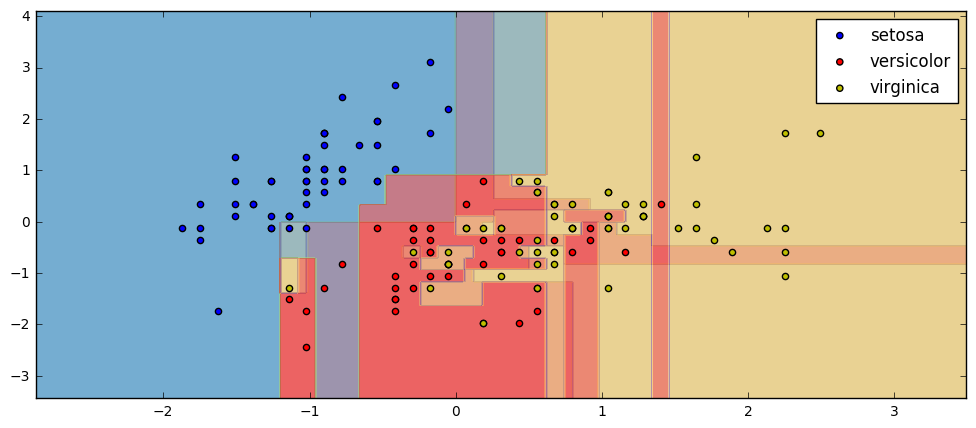

In [49]:
n_estimators = 2
plot_colors = "bry"
plot_step = 0.02
x  = preprocessing.StandardScaler().fit_transform(iris.data[:, :2])
y = iris.target
rfc = RandomForestClassifier(n_estimators=n_estimators)
rfc.fit(x, y)
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
f =  np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(12, 5))
for i, tree in enumerate(rfc.estimators_):
    z = tree.predict(f).reshape(xx.shape)
    cs = plt.contourf(xx, yy, z, alpha=1. / n_estimators, cmap=plt.cm.Paired)
    plt.axis("tight")
for i, c in zip(range(3), plot_colors):
    idx = np.where(y == i)
    plt.scatter(x[idx, 0], x[idx, 1], c=c, label=iris.target_names[i],
    cmap=plt.cm.Paired)
plt.legend(scatterpoints=1)
plt.show()


### 8) Comparez les scores par 6-fold cross-validation des Random Forests et des arbres de décisions purs , sur le dataset iris.

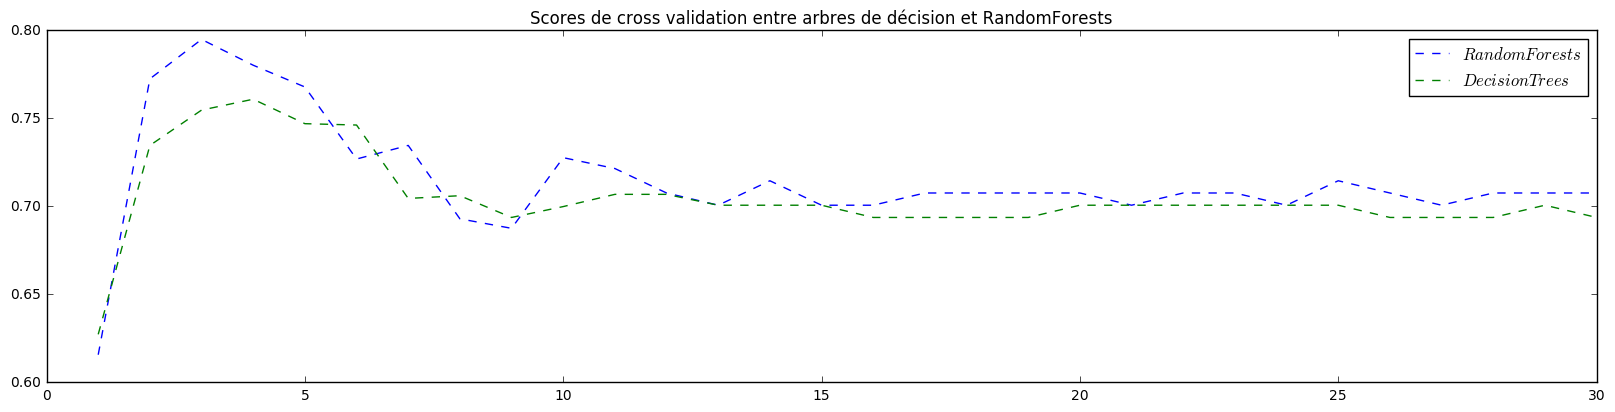

In [50]:
from sklearn.tree import DecisionTreeClassifier
depths = range(1, 31, 1)
iris = load_iris()

X  = preprocessing.StandardScaler().fit_transform(iris.data[:,:2])
y = iris.target
rfscores = []
dtscores = []

for d in depths :
    rfc = RandomForestClassifier(max_depth = d)
    dt  = DecisionTreeClassifier(max_depth = d)
    rfscores.append(np.mean(cross_val_score(rfc, X, y, n_jobs=-1, cv = 6)))
    dtscores.append(np.mean(cross_val_score(dt, X, y, n_jobs=-1, cv = 6,)))

    
plt.figure(figsize=(20,10))
plt.subplot(2,1, 1)
plt.plot(range(1,31,1), rfscores, "b", label="$RandomForests$", linestyle='dashed')
plt.plot(range(1,31,1), dtscores, "g", label="$DecisionTrees$", linestyle='dashed')
plt.title("Scores de cross validation entre arbres de décision et RandomForests")
plt.legend(loc='best', numpoints=1)
plt.show()



### 9) Démontrez : Le minimiseur de la fonction $f → R_{exp}(f) = \mathbb{E}[\exp \ (−Y f(x)]$ est atteint en  $f_{\exp}^{*} = \frac{1}{2} \log{\frac{\eta{(x)}}{1-\eta{(x)}}}$ 


Nous avons :
$ (1) \ \ E[e^{-Y f(x)}/x] = \sum_y e^{-yf(x)} \mathbb{P}(Y=y/x)$
$ = \mathbb{P}(y=1/x)e^{-F(x)} + \mathbb{P}(y=-1/x)e^{F(x)}$

On dérive par rapport à $F(x)$ et on cherche le F tel que :
$\frac{\partial(1)}{\partial F(x)} = - \eta(x) e^{-F(x)} + (1-\eta(x)) e^{F(x)} = 0$
$ \Leftrightarrow \frac{e^{F(x)}}{e^{-F(x)}} = \frac{\eta(x)}{1-\eta(x)}$
$ \Leftrightarrow e^{2F(x)} = \frac{\eta(x)}{1-\eta(x)}$
$ \Leftrightarrow f^*_{exp}(x)= \frac{1}{2} log(\frac{\eta(x)}{1-\eta(x)})$

### 10) En déduire que le classifieur de Bayes associé au risque $R_{exp}$ est le même que le classifieur de Bayes associé au risque 0/1, $R_{\rho_{0} }$
On a pour le classifieur de Bayes au risque 0/1 : $ h^{*}_{\rho_{0}} = sign(2\eta(x) -1)$

Et le classifieur de bayes pour le  risque $R_{exp}$ :
$ h^{*}_{\exp} = sign[ \frac{1}{2} log(\frac{\eta(x)}{1-\eta(x)})]$
Si l'on pose :  $\eta(x) = \mathbb{P}(y=1/x) $

Alors , si l'on cherche les valeurs de $\eta(x)$ pour lesquelles $ h^{*}_{\rho_{0}}$ et  $h^{*}_{\exp}$ s'annulent, nous avons $\eta^{*}(x) = \frac{1}{2}$. Les deux classifieurs étant croissants, ils classifient de la façon suivante : -1 si $\eta(x) < \frac{1}{2}$ et 1 si $\eta(x)> \frac{1}{2}$



### 13) Mettre en oeuvre ADABOOST avec des arbres de profondeur 1, puis 2, puis 10, sur le jeu de données digits. On calculera notamment la précision obtenue par 6-fold cross-validation.

In [51]:
from sklearn.ensemble import AdaBoostClassifier
depths = [1,2, 10]
scores = []
X  = preprocessing.StandardScaler().fit_transform(digits.data)
y = digits.target
for d in depths :
    ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = d), algorithm='SAMME')
    scores.append(np.mean(cross_val_score(ada, X, y, n_jobs=-1, cv = 6)))

print("Scores 6-fold adaboost :", scores)



Scores 6-fold adaboost : [0.71700163961838947, 0.81876923928037326, 0.94882255049502262]


### 14) Appliquer AdaBoost sur les données digits découpées en deux échantillons : apprentissage (75%) et test (25%). Tracer les erreurs (0/1) d’apprentissage et de test en fonction du nombre d’itérations.

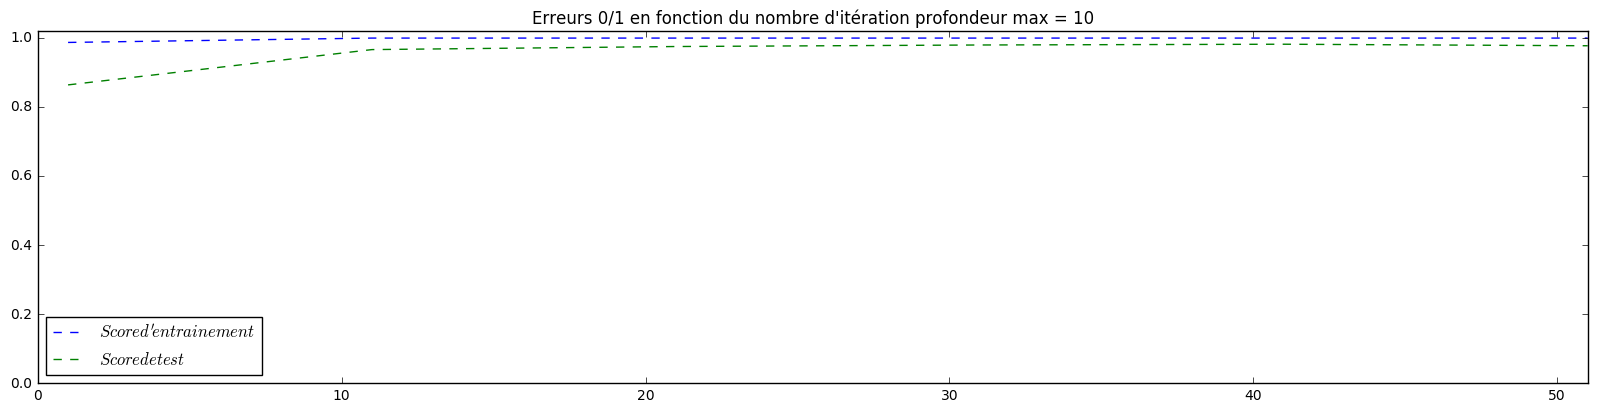

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
nestimators = range(1,60,10)
errorsTrain = []
errorsTest = []
for n in nestimators :
    ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 10), algorithm='SAMME', n_estimators=n)
    ada.fit(X_train, y_train)
    errorsTrain.append(ada.score(X_train, y_train))
    errorsTest.append(ada.score(X_test, y_test))

plt.figure(figsize=(20,10))
plt.subplot(2,1, 1)
plt.plot(nestimators, errorsTrain, "b", label="$Score d'entrainement$", linestyle='dashed')
plt.plot(nestimators, errorsTest, "g", label="$Score de test$", linestyle='dashed')
plt.title("Erreurs 0/1 en fonction du nombre d'itération profondeur max = 10")
plt.ylim([0, 1.02])
plt.xlim([0, 51])
plt.legend(loc='best', numpoints=1)
plt.show()

### 15) Que remarquez vous ? Que se passe-t-il si la profondeur des arbres de classification est grande ?

Nous pouvons voir que l'erreur de test diminue rapidement avec l'augmentation du nombre d'itération.

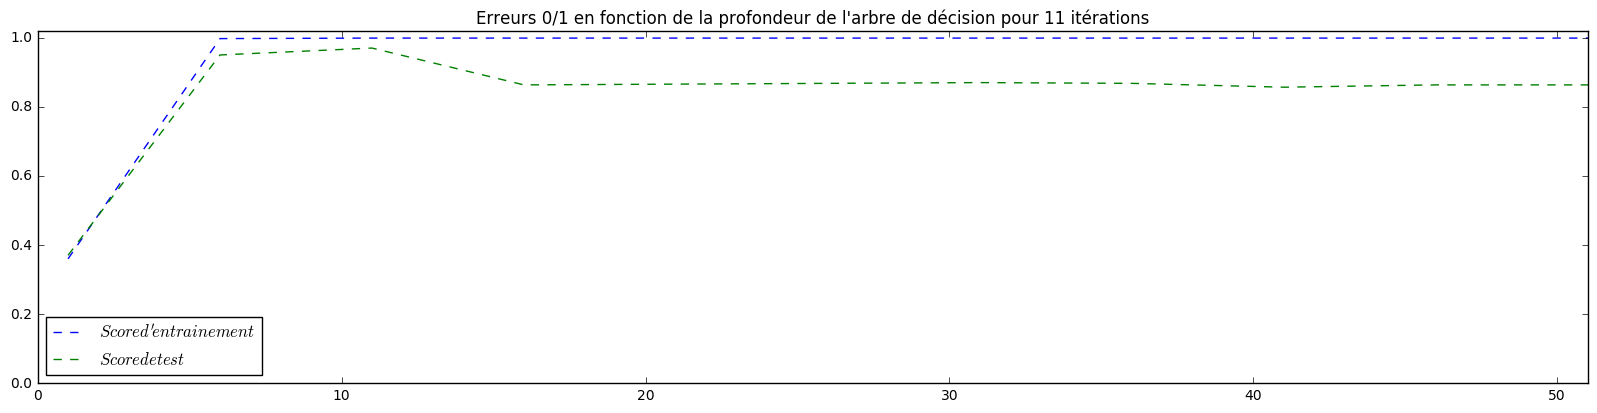

In [53]:
# Voyons l'impact de la profondeur de l'arbre en prennant 11 itérations.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
depths = range(1,60,5)
errorsTrain = []
errorsTest = []
for d in depths :
    ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = d), algorithm='SAMME', n_estimators=11)
    ada.fit(X_train, y_train)
    errorsTrain.append(ada.score(X_train, y_train))
    errorsTest.append(ada.score(X_test, y_test))

plt.figure(figsize=(20,10))
plt.subplot(2,1, 1)
plt.plot(depths, errorsTrain, "b", label="$Score d'entrainement$", linestyle='dashed')
plt.plot(depths, errorsTest, "g", label="$Score de test$", linestyle='dashed')
plt.title("Erreurs 0/1 en fonction de la profondeur de l'arbre de décision pour 11 itérations")
plt.ylim([0, 1.02])
plt.xlim([0, 51])
plt.legend(loc='best', numpoints=1)
plt.show()

Nous voyons que la profondeur de l'arbre de décision peut provoquer de l'overfitting car au-delà de 10 à 12 le score de test diminue.